# **Import Library**

In [7]:
import zipfile
import xml.etree.ElementTree as ET
import os
import ultralytics
import shutil
import yaml
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import timm
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from torch.nn import functional as F
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import math
import gdown
print(gdown.__version__)

5.2.0


# **Text Detection**

In [8]:
gdown.download('https://drive.google.com/uc?id=1cBiff7HEbaQsUGVhbdi5wmj83e9dDgU8', 'SceneTrialTrain.zip', quiet=False)
with zipfile.ZipFile("SceneTrialTrain.zip", "r") as zip_ref:
    zip_ref.extractall("datasets")


Downloading...
From (original): https://drive.google.com/uc?id=1cBiff7HEbaQsUGVhbdi5wmj83e9dDgU8
From (redirected): https://drive.google.com/uc?id=1cBiff7HEbaQsUGVhbdi5wmj83e9dDgU8&confirm=t&uuid=0949cc85-0e1a-45e0-8346-11866a5a1676
To: e:\Github_Project\STR-full-pipeline\SceneTrialTrain.zip
100%|██████████| 45.7M/45.7M [00:01<00:00, 29.4MB/s]


In [9]:
words_xml_path = './datasets/SceneTrialTrain/words.xml'
tree = ET.parse(words_xml_path)
root = tree.getroot()
print(root)
for image in root:
  img_name =(image[0].text)
  img_size = image[1].attrib['x'],image[1].attrib['y']
  for bbs in image.findall('taggedRectangles'):
    for bb in bbs:
      bbox = [bb.attrib['x'],bb.attrib['y'],bb.attrib['width'],bb.attrib['height']]
      print(bb[0].text,bbox)
  break




<Element 'tagset' at 0x000002045F209AD0>
self ['174.0', '392.0', '274.0', '195.0']
adhesive ['512.0', '391.0', '679.0', '183.0']
address ['184.0', '612.0', '622.0', '174.0']
labels ['863.0', '599.0', '446.0', '187.0']
36 ['72.0', '6.0', '95.0', '87.0']
89m ['247.0', '2.0', '197.0', '88.0']
cls ['792.0', '0.0', '115.0', '81.0']
250 ['200.0', '848.0', '228.0', '139.0']
on ['473.0', '878.0', '165.0', '109.0']
a ['684.0', '878.0', '71.0', '106.0']
roll ['806.0', '844.0', '218.0', '141.0']


In [10]:
def extract_data_from_xml(path):
  tree = ET.parse(path)
  root = tree.getroot()
  image_paths = []
  image_sizes = []
  image_labels = []
  bounding_boxes = []
  for image in root:
    bbs_of_img = []
    labels_of_img = []
    image_paths.append(image[0].text)
    image_sizes.append((float(image[1].attrib['x']),float(image[1].attrib['y'])))
    for bbs in image.findall('taggedRectangles'):
      for bb in bbs:
        if not bb[0].text.isalnum():
          continue
        if '£' in bb[0].text.lower() or 'é'in bb[0].text.lower() or 'ñ' in bb[0].text.lower():
          continue
        x1 = float(bb.attrib['x'])
        y1 = float(bb.attrib['y'])
        width = float(bb.attrib['width'])
        height = float(bb.attrib['height'])
        bbs_of_img.append([x1,y1,width,height])
        labels_of_img.append(bb[0].text.lower())
    bounding_boxes.append(bbs_of_img)
    image_labels.append(labels_of_img)
  return image_paths,image_sizes,image_labels,bounding_boxes





In [11]:
def change_to_yolo_format(image_paths,image_sizes,bounding_boxes):
  yolo_data = []
  for idx,img_path in enumerate(image_paths):
    img_width,img_height = image_sizes[idx]
    bbs_of_img = []
    for bbox in bounding_boxes[idx]:
      x1,y1,bb_width,bb_height = bbox[0],bbox[1],bbox[2],bbox[3]
      x_center = (x1 + bb_width/2) / img_width
      y_center = (y1 + bb_height/2) / img_height
      width = bb_width / img_width
      height = bb_height/img_height
      bbs_of_img.append(f'0 {x_center} {y_center} {width} {height}')
    yolo_data.append((img_path,bbs_of_img))
  return yolo_data

In [12]:
dataset_dir = './datasets/SceneTrialTrain'
words_xml_path = os.path.join(dataset_dir,'words.xml')
image_paths,image_sizes,image_labels,bounding_boxes = extract_data_from_xml(words_xml_path)
yolo_data = change_to_yolo_format(image_paths,image_sizes,bounding_boxes)
print(f'Number of image {len(image_paths)}')
print(image_sizes[0])
print(image_labels[0])
print(yolo_data[1])


Number of image 250
(1600.0, 1200.0)
['self', 'adhesive', 'address', 'labels', '36', '89m', 'cls', '250', 'on', 'a', 'roll']
('apanar_06.08.2002/IMG_1263.JPG', ['0 0.5346875 0.6008333333333333 0.529375 0.14333333333333334'])


# **Store Yolo Data**

In [ ]:
def save_data(data,src_img_dir,save_dir):
  os.makedirs(save_dir,exist_ok=True)
  save_image_dir = os.path.join(save_dir,'images')
  save_label_dir = os.path.join(save_dir,'labels')
  os.makedirs(save_image_dir,exist_ok=True)
  os.makedirs(save_label_dir,exist_ok=True)
  for image_path,yolo_labels in data:
    shutil.copy(
        os.path.join(src_img_dir,image_path),save_image_dir
    )
    image_name = os.path.basename(image_path)
    image_name = os.path.splitext(image_name)[0]
    with open(os.path.join(save_label_dir,f'{image_name}.txt'),'w') as f:
      for label in yolo_labels:
        f.write(f'{label}\n')


In [ ]:
train_data,val_data = train_test_split(yolo_data,
                                       test_size=0.2,shuffle=True)
train_data,test_data = train_test_split(train_data,test_size=0.1,shuffle=True)
save_yolo_data_dir = os.path.join(dataset_dir,'yolo_data')
os.makedirs(save_yolo_data_dir,exist_ok=True)
train_yolo_data_dir = os.path.join(save_yolo_data_dir,'train')
val_yolo_data_dir = os.path.join(save_yolo_data_dir,'val')
test_yolo_data_dir = os.path.join(save_yolo_data_dir,'test')
save_data(train_data,dataset_dir,train_yolo_data_dir)
save_data(val_data,dataset_dir,val_yolo_data_dir)
save_data(test_data,dataset_dir,test_yolo_data_dir)
class_labels = ['text']
data_yaml = {
    'path': './datasets/SceneTrialTrain/yolo_data',
    'train': 'train/images',
    'test': 'test/images',
    'val': 'val/images',
    'nc': 1,
    'names': class_labels
}
yolo_yaml_path = os.path.join(dataset_dir,'data.yml')
with open(yolo_yaml_path,'w') as f:
  yaml.dump(data_yaml,f,default_flow_style=False)


# **Yolo Training**

In [ ]:
model = ultralytics.YOLO('yolo11m.pt')
results = model.train(
    data = yolo_yaml_path,
    epochs=50,
    imgsz=640,
    cache=True,
    patience=20,
    plots=True
)

Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./datasets/SceneTrialTrain/data.yml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pretr

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

  8                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1    990976  ultralytics.nn.modules.block.C2PSA           [512, 512, 1]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1   1642496  ultralytics.nn.modules.block.C3k2            [1024, 512, 1, True]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1    542720  ultralytics.nn.modules.block.C3k2            [1024

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1283.4±409.6 MB/s, size: 123.6 KB)


train: Scanning /content/datasets/SceneTrialTrain/yolo_data/train/labels... 180 images, 7 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<00:00, 1463.94it/s]

train: New cache created: /content/datasets/SceneTrialTrain/yolo_data/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.2GB RAM): 100%|██████████| 180/180 [00:01<00:00, 176.99it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1089.1±741.9 MB/s, size: 97.4 KB)


val: Scanning /content/datasets/SceneTrialTrain/yolo_data/val/labels... 50 images, 2 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 457.43it/s]

val: New cache created: /content/datasets/SceneTrialTrain/yolo_data/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 50/50 [00:00<00:00, 53.67it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.91G      2.056      2.954      1.816         32        640: 100%|██████████| 12/12 [00:23<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.85s/it]

                   all         50        204      0.434      0.529      0.426      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.12G      1.265      1.472      1.185         11        640: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         50        204      0.333      0.471      0.288      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.13G      1.216      1.256      1.141         17        640: 100%|██████████| 12/12 [00:06<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         50        204      0.254      0.701      0.249      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.18G      1.255      1.241      1.178         48        640: 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         50        204     0.0285     0.0931     0.0061    0.00208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.18G      1.344      1.223      1.259         24        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         50        204     0.0261      0.142     0.0085    0.00262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.16G      1.278       1.08      1.197         21        640: 100%|██████████| 12/12 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         50        204    0.00256      0.103     0.0012   0.000412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.12G      1.305      1.081      1.211         44        640: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         50        204    0.00383       0.24    0.00248   0.000729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.16G      1.379      1.122       1.23         63        640: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         50        204     0.0105     0.0294    0.00121   0.000508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.16G      1.259      1.127      1.191         37        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         50        204     0.0198      0.098    0.00685    0.00241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.16G      1.267       1.04      1.195         52        640: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         50        204     0.0195     0.0441     0.0066    0.00258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.17G      1.276      1.101      1.158         28        640: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         50        204     0.0097      0.245    0.00618    0.00256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.15G      1.179     0.9821      1.128         34        640: 100%|██████████| 12/12 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         50        204     0.0234      0.593     0.0188    0.00997



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.15G      1.182     0.9506      1.146         23        640: 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         50        204      0.165      0.603      0.141     0.0767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.17G      1.189     0.9305      1.143         63        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         50        204       0.29      0.618      0.233      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.18G      1.187     0.9451      1.157         16        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         50        204      0.593      0.652      0.534      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      8.12G      1.145     0.9328      1.146         25        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         50        204      0.391      0.701      0.345      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.16G      1.078     0.8542      1.103         27        640: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         50        204      0.681      0.637      0.644      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.15G      1.111     0.8808      1.118         32        640: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         50        204      0.593      0.662      0.606       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.16G      1.135     0.8785      1.106         24        640: 100%|██████████| 12/12 [00:06<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         50        204      0.637       0.73      0.667      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.12G      1.095     0.8609      1.121         18        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         50        204      0.687      0.696      0.676      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      8.15G      1.092     0.8179      1.078         29        640: 100%|██████████| 12/12 [00:06<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         50        204      0.651      0.765      0.648      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.15G     0.9796     0.8072      1.078         37        640: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         50        204       0.65      0.725      0.674      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.15G      1.018     0.7724      1.094         35        640: 100%|██████████| 12/12 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         50        204      0.743      0.799      0.776       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.24G      1.049     0.8215      1.087         14        640: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         50        204      0.839      0.791      0.771      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.15G       1.02     0.7899       1.07         41        640: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         50        204      0.752      0.819      0.771      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      8.16G      1.014     0.7986      1.084         29        640: 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         50        204      0.823       0.77      0.772      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.14G     0.9619     0.7665      1.053         21        640: 100%|██████████| 12/12 [00:06<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         50        204       0.83      0.799       0.78      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.12G      1.002     0.7514      1.047         51        640: 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         50        204      0.821      0.762       0.78      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.17G     0.9439     0.6882      1.037         37        640: 100%|██████████| 12/12 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         50        204      0.855      0.794      0.809      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      8.12G      0.983     0.7273      1.041         27        640: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         50        204       0.87      0.789       0.81      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      8.14G      0.919     0.6748       1.03         42        640: 100%|██████████| 12/12 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         50        204      0.795       0.78       0.79      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.16G     0.9188     0.6526      1.018         29        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         50        204      0.833      0.779       0.75      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.12G     0.8962      0.654      1.006         87        640: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         50        204      0.824      0.789      0.776      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      8.15G      0.929     0.6537      1.029         24        640: 100%|██████████| 12/12 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         50        204      0.854      0.824      0.829      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.15G     0.8956     0.6199     0.9899         44        640: 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         50        204      0.865      0.816      0.844      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.16G     0.8955     0.6281      1.014         26        640: 100%|██████████| 12/12 [00:06<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         50        204      0.876      0.809      0.838      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.16G      0.889      0.631      1.012         60        640: 100%|██████████| 12/12 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         50        204        0.9      0.784      0.837      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.16G     0.8375     0.6102     0.9838         30        640: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         50        204      0.869      0.813      0.844      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.15G     0.8436     0.6126      1.013         23        640: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         50        204      0.885      0.795       0.83      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.16G     0.8452     0.6175     0.9947         32        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         50        204      0.864      0.804      0.817       0.59


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.14G     0.8492     0.6514     0.9772         23        640: 100%|██████████| 12/12 [00:07<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         50        204      0.876      0.764      0.791      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.12G     0.8147     0.5808     0.9645         28        640: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         50        204      0.868      0.789      0.827      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.15G     0.8046     0.5919     0.9397         11        640: 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         50        204      0.857      0.823      0.825      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.16G     0.7914     0.5824     0.9513         25        640: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         50        204      0.869      0.812      0.816      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.15G     0.7587     0.5656     0.9524         18        640: 100%|██████████| 12/12 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         50        204       0.88      0.814      0.814      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.15G     0.7383     0.5256     0.9232         15        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         50        204      0.866      0.822      0.825      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.18G     0.7546     0.5477     0.9495         14        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         50        204      0.857      0.814      0.829      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.15G     0.7318     0.5223     0.9154         25        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all         50        204       0.87      0.821      0.841      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.17G     0.7239     0.5187     0.9294         14        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         50        204      0.875      0.814      0.852      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      8.17G     0.7023     0.5183     0.9191         16        640: 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         50        204      0.878      0.833      0.854      0.657



50 epochs completed in 0.122 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


                   all         50        204      0.877      0.833      0.854      0.656
Speed: 0.2ms preprocess, 10.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train


# **Text Recognition**

In [4]:
def extract_data_from_xml(path):
  tree = ET.parse(path)
  root = tree.getroot()
  image_paths = []
  image_sizes = []
  image_labels = []
  bounding_boxes = []
  for image in root:
    bbs_of_img = []
    labels_of_img = []
    image_paths.append(image[0].text)
    image_sizes.append((float(image[1].attrib['x']),float(image[1].attrib['y'])))
    for bbs in image.findall('taggedRectangles'):
      for bb in bbs:
        if not bb[0].text.isalnum():
          continue
        if '£' in bb[0].text.lower() or 'é'in bb[0].text.lower() or 'ñ' in bb[0].text.lower():
          continue
        x1 = float(bb.attrib['x'])
        y1 = float(bb.attrib['y'])
        width = float(bb.attrib['width'])
        height = float(bb.attrib['height'])
        bbs_of_img.append([x1,y1,width,height])
        labels_of_img.append(bb[0].text.lower())
    bounding_boxes.append(bbs_of_img)
    image_labels.append(labels_of_img)
  return image_paths,image_sizes,image_labels,bounding_boxes
dataset_dir = './datasets/SceneTrialTrain'
image_paths,image_sizes,image_labels,bounding_boxes = extract_data_from_xml(os.path.join(dataset_dir,'words.xml'))

print(len(image_paths))
print(sum([len(bbox) for bbox in bounding_boxes]))

250
1097


In [5]:
def split_bounding_boxes(dataset_dir,image_paths,image_labels,bboxes,save_dir):
  os.makedirs(save_dir,exist_ok=True)
  count = 0
  labels = []
  for img_path,img_label, bbs in zip(image_paths,image_labels,bboxes):
    img_path = os.path.join(dataset_dir,img_path)
    img = Image.open(img_path)
    for label,bbox in zip(img_label,bbs):
      cropped_img = img.crop((bbox[0],bbox[1],bbox[0]+bbox[2],bbox[1]+bbox[3]))
      if np.mean(cropped_img) < 35 or np.mean(cropped_img) >220: #only black or white
        continue
      if cropped_img.size[0] < 10 or cropped_img.size[1] < 10: # too small
        continue
      filename = f'{count:06d}.jpg'
      new_img_path = os.path.join(save_dir,filename)
      cropped_img.save(new_img_path)
      label = new_img_path + '\t' + label
      labels.append(label)
      count+=1
  labels_file_path = os.path.join(save_dir,'labels.txt')
  with open(labels_file_path,'w') as f:
    for label in labels:
      f.write(f'{label}\n')
  return labels_file_path




In [6]:
ocr_dataset_dir = os.path.join(dataset_dir,'ocr_dataset')
labels_file_path = split_bounding_boxes(dataset_dir,image_paths,image_labels,bounding_boxes,ocr_dataset_dir)
print(len(os.listdir(ocr_dataset_dir)))



1089


In [7]:
img_paths = []
labels = []
with open(labels_file_path,'r') as f:
  for label in f:
    img_paths.append(label.strip().split('\t')[0])
    labels.append(label.strip().split('\t')[1])
print(len(img_paths))

1088


# **Create a vocabulary**

In [8]:
letters = [char.lower() for char in labels]
letters = ''.join(letters)
chars = sorted(list(set(letters)))
blank = '-'
chars += blank

In [9]:
def encode(label,chars_2_idx,max_label_len):
  encoded_label = torch.tensor(
        [chars_2_idx[char] for char in label],dtype=torch.long
  )
  seq_len = len(encoded_label)
  encoded_label = F.pad(encoded_label,pad=(0,max_label_len-seq_len),value=0)
  return encoded_label,seq_len
def decode(encoded_labels,idx_2_chars,blank_char='-'):
  decoded_labels = []
  for seq in encoded_labels:
    decoded_label = []
    prev_char = None
    for token in seq:
      if token != 0:
        char = idx_2_chars[token.item()]
        if char != blank_char:
          if char != prev_char or prev_char == blank_char:
            decoded_label.append(char)
        prev_char = char
    decoded_label = ''.join(decoded_label)
    decoded_labels.append(decoded_label)
  return decoded_labels


In [10]:
chars_2_idx = {char: idx+1 for idx,char in enumerate(chars)}
idx_2_chars = {idx+1: char for idx,char in enumerate(chars)}
max_label_len = max([len(label) for label in labels])

In [11]:
print(encode('food',chars_2_idx,max_label_len))
print(decode([torch.tensor([29,29,15,15,37,22,16])],idx_2_chars,blank_char='-'))

(tensor([16, 25, 25, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), 4)
['self']


# **Data Preprocessing**

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(
            num_output_channels=1
        ),
        transforms.Resize((100,420)),

        transforms.ColorJitter(
            brightness=0.5,
            contrast=0.5,
            saturation=0.5
        ),

        transforms.GaussianBlur(3),
        transforms.RandomAffine(
            degrees=1,
            shear=1
        ),
        transforms.RandomPerspective(
            distortion_scale=0.3,
            p=0.5,
            interpolation=3
        ),
        transforms.RandomRotation(degrees=2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,))
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((100,420)),

        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,))
    ])


}

# **Create Dataset and DataLoader**

In [13]:
class STRDataset(Dataset):
  def __init__(
      self,X,y,chars_2_idx,
      max_label_len,label_encoder=None,transforms=None
  ):
    super().__init__()
    self.img_paths = X
    self.labels = y
    self.chars_2_idx = chars_2_idx
    self.max_label_len = max_label_len
    self.label_encoder = label_encoder
    self.transforms = transforms
  def __len__(self):
    return len(self.img_paths)
  def __getitem__(self,idx):
    label = self.labels[idx]
    img_path = self.img_paths[idx]
    img = Image.open(img_path).convert('RGB')
    if self.transforms != None:
      img = self.transforms(img)
    if self.label_encoder:
      encoded_label, label_len = self.label_encoder(
          label,self.chars_2_idx,self.max_label_len
      )
    return img,encoded_label,label_len,img_path


In [14]:
batch_size = 32
X_train,X_val,y_train,y_val = train_test_split(img_paths,labels,test_size=0.1,shuffle=True)
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.1,shuffle=True)
train_dataset = STRDataset(X_train,y_train,chars_2_idx,
                           max_label_len,encode,data_transforms['train'])
val_dataset = STRDataset(X_val,y_val,chars_2_idx,
                         max_label_len,encode,data_transforms['val'])
test_dataset = STRDataset(X_test,y_test,chars_2_idx,
                          max_label_len,encode,data_transforms['val'])
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)


In [ ]:
for img,encoded_label,label_len,img_paths in train_loader:
  print(img.shape)
  print(encoded_label.shape)
  break

torch.Size([32, 1, 100, 420])
torch.Size([32, 14])


In [20]:
class CRNN(nn.Module):
  def __init__(
      self,vocab_size,hidden_size,n_layers,dropout=0.2,unfreeze_layers=3
  ):
    super(CRNN,self).__init__()
    backbone = timm.create_model('resnet50',pretrained=True,in_chans=1)

    modules = list(backbone.children()) [:-2] #Out: Bx2048xHxW
    for layer in modules[-int(unfreeze_layers):]:
      for param in layer.parameters():
        param.requires_grad = True

    modules.append(nn.AdaptiveAvgPool2d((1,None))) #Out: Bx2048x1xW
    self.backbone = nn.Sequential(*modules)
    self.mapSeq = nn.Sequential(
        nn.Linear(2048,512),nn.ReLU(),nn.Dropout(dropout)
    )
    self.gru = nn.GRU(
        512,
        hidden_size,
        n_layers,
        bidirectional=True,
        batch_first=True,
        dropout=dropout
    )
    self.layer_norm = nn.LayerNorm(hidden_size*2)
    self.ff = nn.Sequential(
        nn.Linear(hidden_size*2,hidden_size),nn.ReLU()
    )
    self.batch_norm = nn.BatchNorm1d(hidden_size)
    self.out = nn.Sequential(
        nn.Linear(hidden_size,vocab_size), nn.LogSoftmax(dim=2)
    )
  def forward(self,x): #Bx1xHxW
    x = self.backbone(x) # Bx512x1x14
    x = x.squeeze(2) # Bx512x14
    x = x.permute(0,2,1) # Bx14x512
    x = self.mapSeq(x) # Bx14x256
    x,_ = self.gru(x) # Bx14xhiddensize*2 because of bidirectional
    x = self.layer_norm(x) #Bx14xhiddensize*2
    x = self.ff(x)
    x = x.permute(0,2,1)
    x = self.batch_norm(x)
    x = x.permute(0,2,1)
    x = self.out(x) #Bx14xavocab_size
    x = x.permute(1,0,2) # change shape for CTC
    return x

In [16]:
print(chars_2_idx['-'])

37


In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
hidden_size = 256
n_layers = 3
dropout_rate = 0.2
unfreeze_layers = 3
vocab_size = len(chars) +1
model = CRNN(vocab_size,hidden_size,n_layers,dropout_rate,unfreeze_layers).to(device)
epochs = 100
lr = 1e-3
weight_decay = 1e-5
scheduler_step_size = epochs*0.5
criterion = nn.CTCLoss(
    blank = chars_2_idx['-'],
    zero_infinity=True
)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr = lr,
    weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,step_size=scheduler_step_size,gamma=0.1
)


In [23]:
def evaluate(model,dataloader,criterion,device):
  model.eval()
  losses = []
  with torch.no_grad():
    for inputs,labels,labels_len,img_paths in dataloader:
      inputs, labels,labels_len = inputs.to(device),labels.to(device),labels_len.to(device)
      outputs = model(inputs)
      logits_len = torch.full(
          size = (outputs.size(1),),fill_value=outputs.size(0),dtype=torch.long
      ).to(device)
      loss = criterion(outputs,labels,logits_len,labels_len)
      losses.append(loss.item())
    losses = sum(losses)/len(losses)
  return losses
def fit(train_loader,val_loader,model,criterion,optimizer,scheduler,device,epochs):
  train_losses = []
  val_losses = []
  best_val_loss = 1000
  for epoch in range(epochs):
    batch_train_losses = []
    model.train()
    for idx, (inputs,labels,labels_len,img_paths) in enumerate(train_loader):
      inputs,labels,labels_len = inputs.to(device),labels.to(device),labels_len.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      logits_lens = torch.full(size=(outputs.size(1),),fill_value=outputs.size(0),dtype=torch.long).to(device) #size of each sample = seq length
      loss = criterion(outputs,labels,logits_lens,labels_len)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(
          model.parameters(),
          2
      )
      optimizer.step()
      batch_train_losses.append(loss.item())
    train_loss = sum(batch_train_losses) / len(batch_train_losses)
    train_losses.append(train_loss)
    val_loss = evaluate(
        model,val_loader,
        criterion,device
    )
    if val_loss < best_val_loss:
      torch.save(model.state_dict(),os.path.join(dataset_dir,'text_reg.pt'))
      best_val_loss = val_loss
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}\tTrain loss:{train_loss}\tVal loss:{val_loss}')
    scheduler.step()
  return train_losses,val_losses

In [24]:
train_losses,val_losses = fit(train_loader,val_loader,model,criterion,optimizer,scheduler,device,epochs)

Epoch 1	Train loss:3.3903704626219615	Val loss:3.162732422351837
Epoch 2	Train loss:3.243189820221492	Val loss:3.0956291556358337
Epoch 3	Train loss:3.187017525945391	Val loss:3.1231265664100647
Epoch 4	Train loss:3.113720944949559	Val loss:3.2384771704673767
Epoch 5	Train loss:3.0320543221064975	Val loss:2.93950617313385
Epoch 6	Train loss:2.9088031308991567	Val loss:2.819676101207733
Epoch 7	Train loss:2.798417772565569	Val loss:2.8622544407844543
Epoch 8	Train loss:2.687497317790985	Val loss:2.55241996049881
Epoch 9	Train loss:2.596664845943451	Val loss:2.4907357692718506
Epoch 10	Train loss:2.392136973994119	Val loss:2.3132933378219604
Epoch 11	Train loss:2.265745601483754	Val loss:2.8446103930473328
Epoch 12	Train loss:2.0936045135770525	Val loss:2.138315498828888
Epoch 13	Train loss:1.8489234106881278	Val loss:1.9638049006462097
Epoch 14	Train loss:1.7375794563974654	Val loss:1.7766154408454895
Epoch 15	Train loss:1.557448753288814	Val loss:1.5975153148174286
Epoch 16	Train loss:

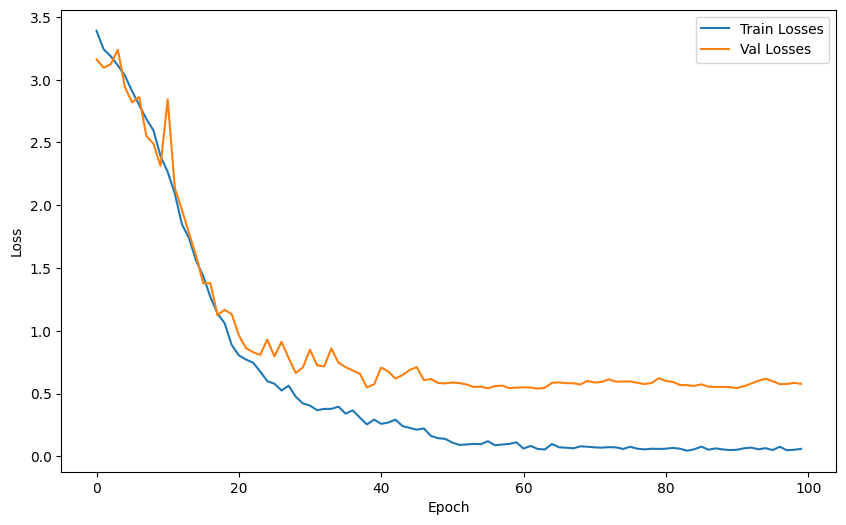

In [25]:
x_axis = range(100)
plt.figure(figsize=(10,6))
plt.plot(x_axis,train_losses[:100],label='Train Losses')
plt.plot(x_axis,val_losses[:100],label='Val Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
model.load_state_dict(torch.load('./datasets/SceneTrialTrain/text_reg.pt',weights_only=True))
print(evaluate(model,val_loader,criterion,device))

0.5391821786761284


In [27]:
def predict(model,dataloader,device,chars_2_idx,decode,idx_2_chars):
  model.eval()
  all_preds=[]
  count = 0
  accuracy = 0
  batch_size = dataloader.batch_size
  num_rows = math.ceil(math.sqrt(batch_size))
  num_cols = math.ceil(batch_size / num_rows)

  with torch.no_grad():
    for inputs,labels,label_len,img_paths in dataloader:
      targets = []
      inputs,labels,label_len = inputs.to(device),labels.to(device),label_len.to(device)
      for label in labels:
        target=''
        for token in label:
          if token != 0:
            target += idx_2_chars[token.item()]
        targets.append(target)
      _,preds_idx = model(inputs).permute(1,0,2).max(2) # Batch size x seqlen
      predicts = []
      for i in range(preds_idx.size(0)):
        pred = ''
        for j in range(preds_idx.size(1)):
          char_idx = preds_idx[i,j].item()
          if char_idx != chars_2_idx['-'] and (j==0 or char_idx != preds_idx[i,j-1].item()):
            pred += idx_2_chars[char_idx]
        predicts.append(pred)
      plt.figure(figsize=(15,num_rows*2))
      for idx, (pred, target) in enumerate(zip(predicts,targets)):
        img = Image.open(img_paths[idx]).convert('RGB')
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.imshow(img)
        ax.set_title(f'Target: {target} | Pred: {pred}', fontsize=10)
        ax.axis('off')
      plt.tight_layout()
      plt.show()

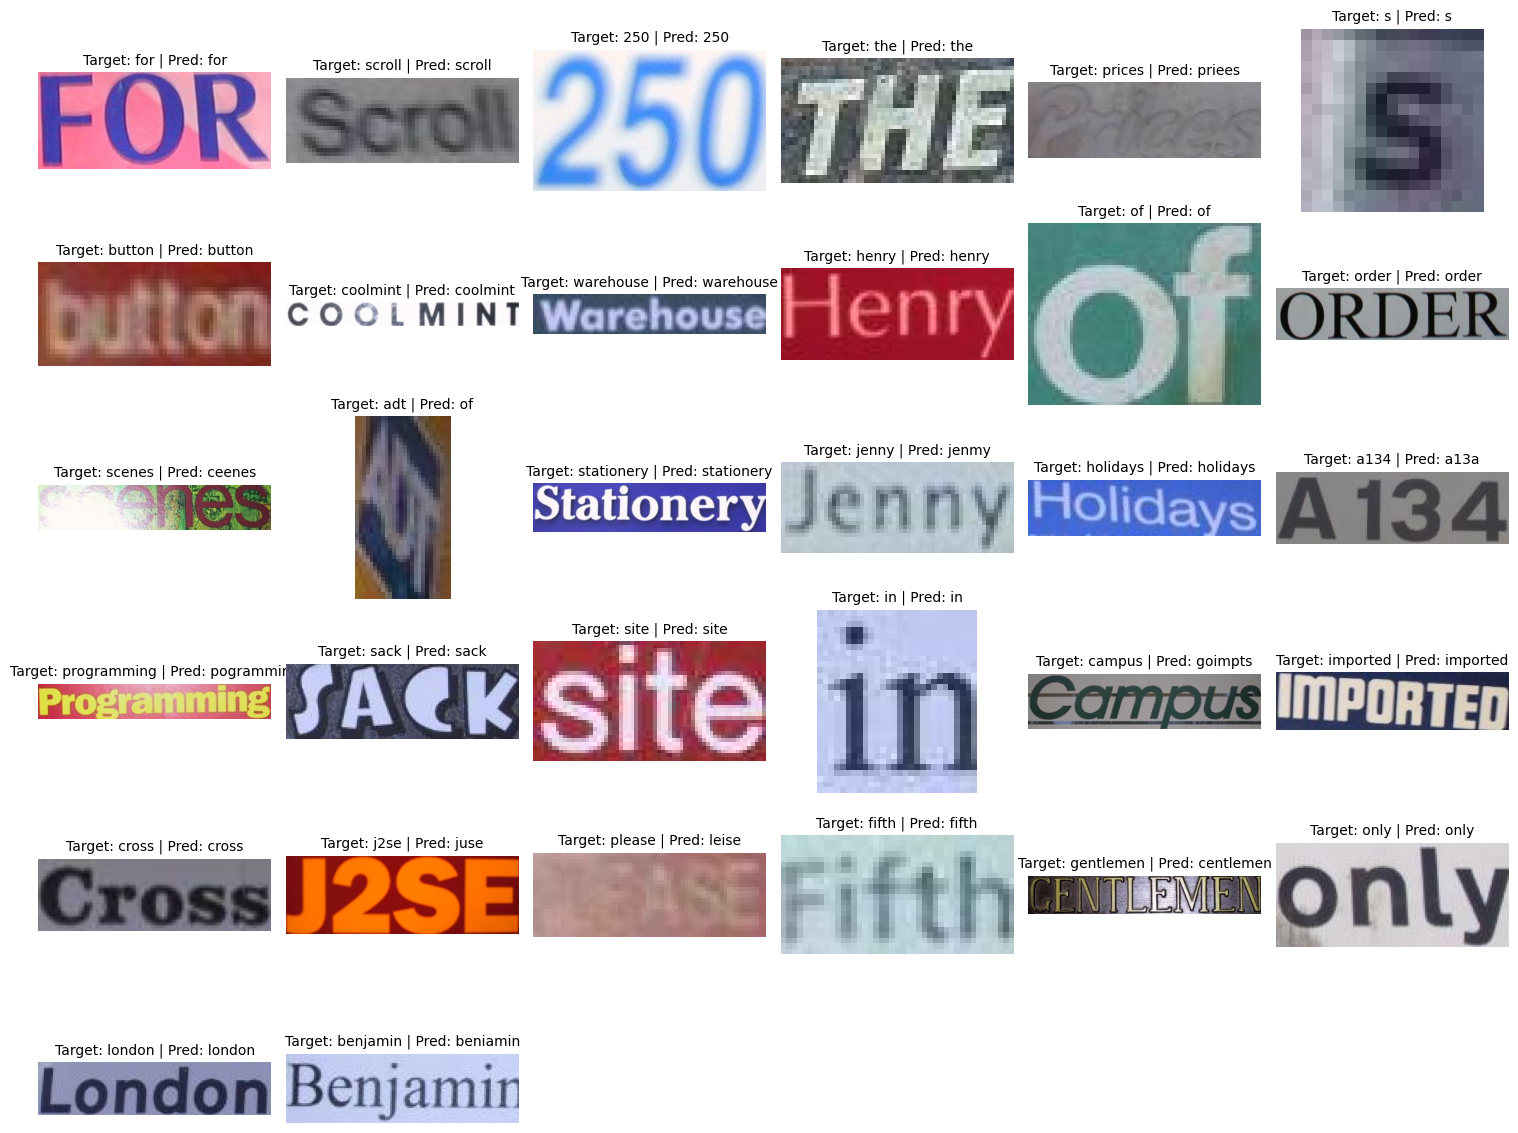

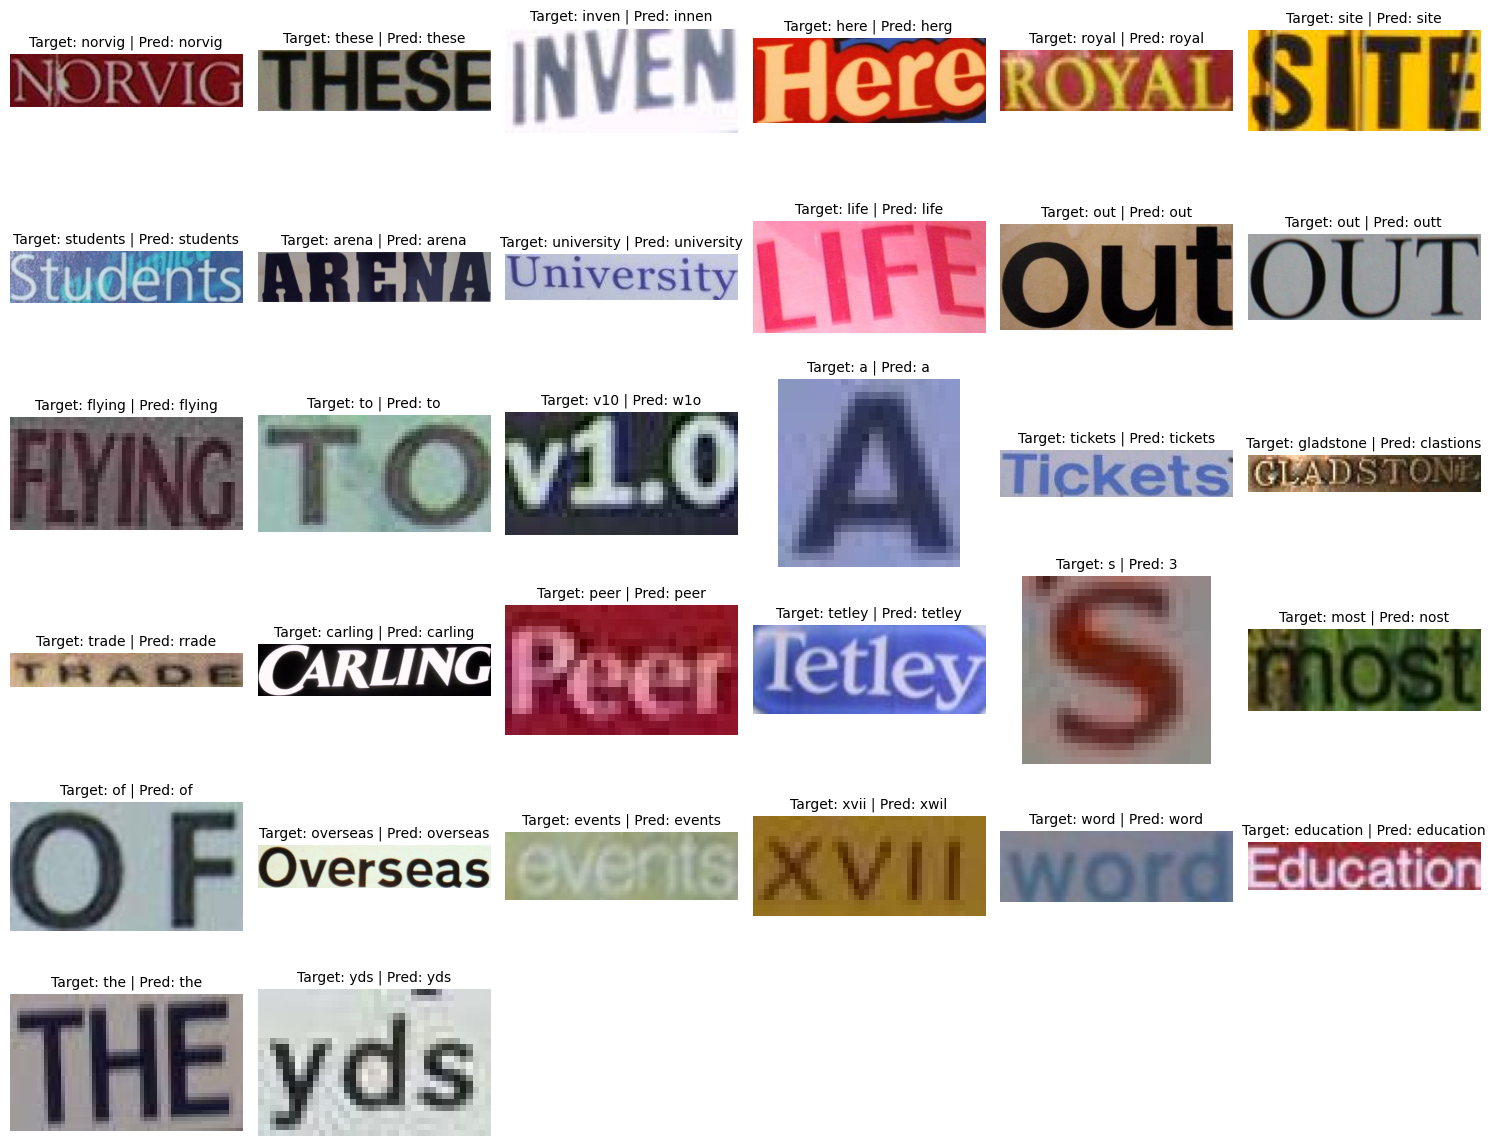

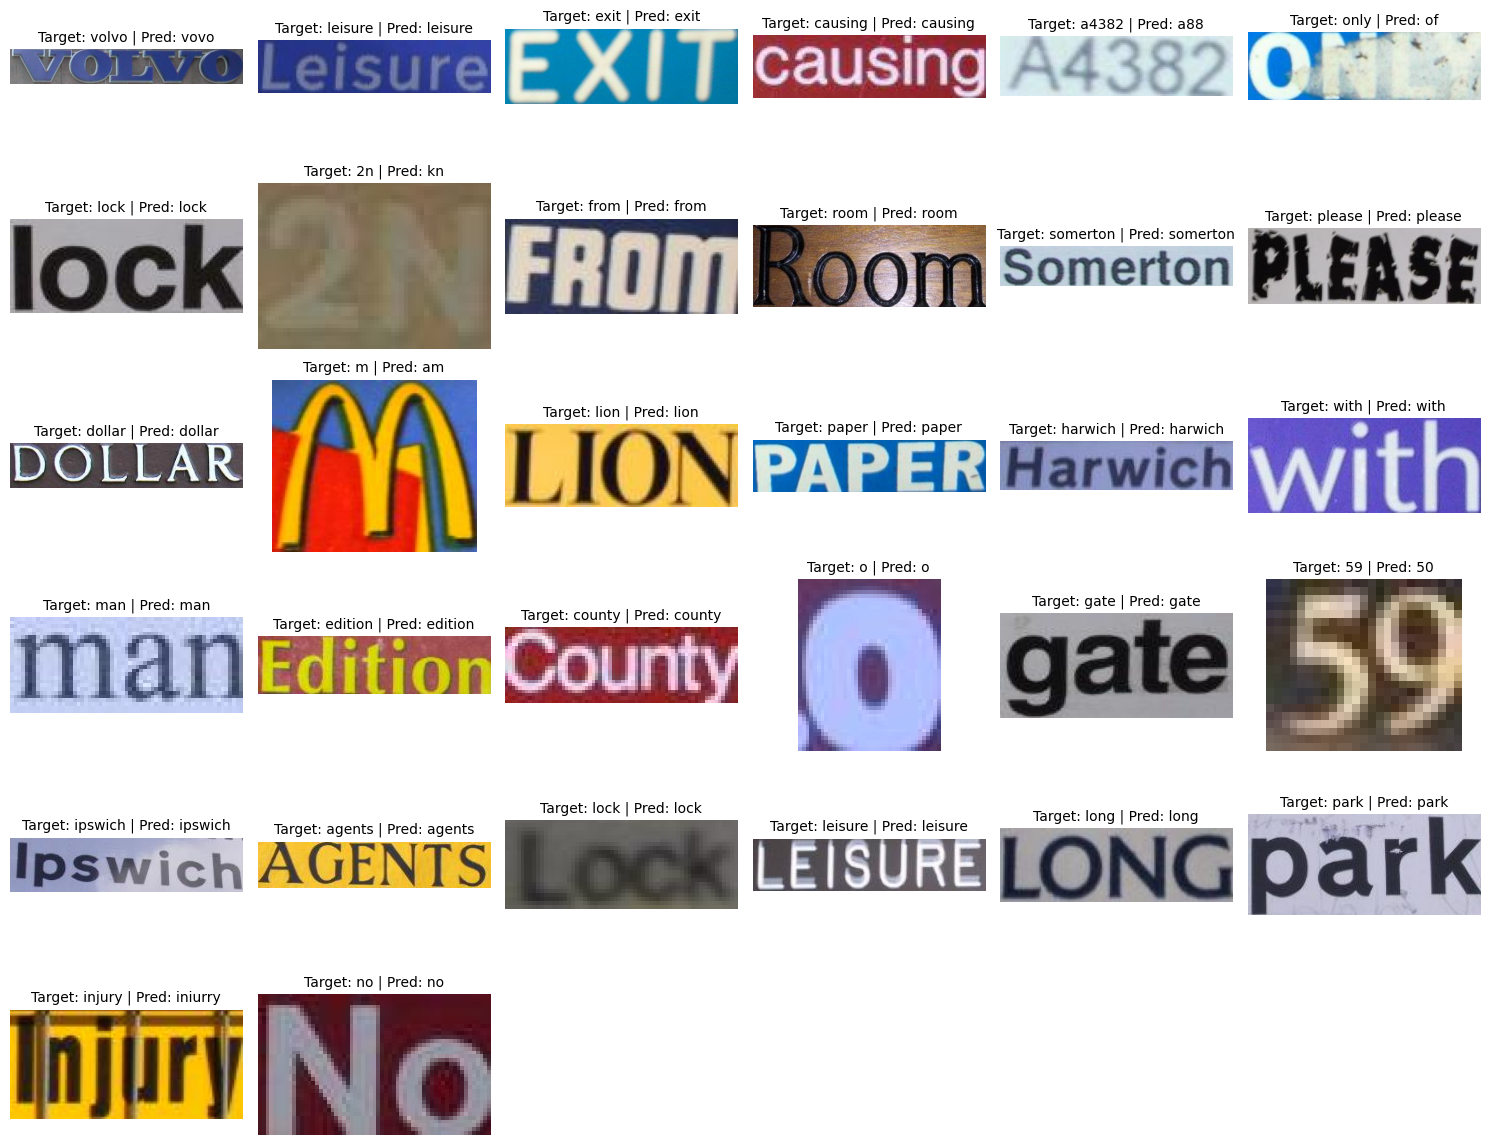

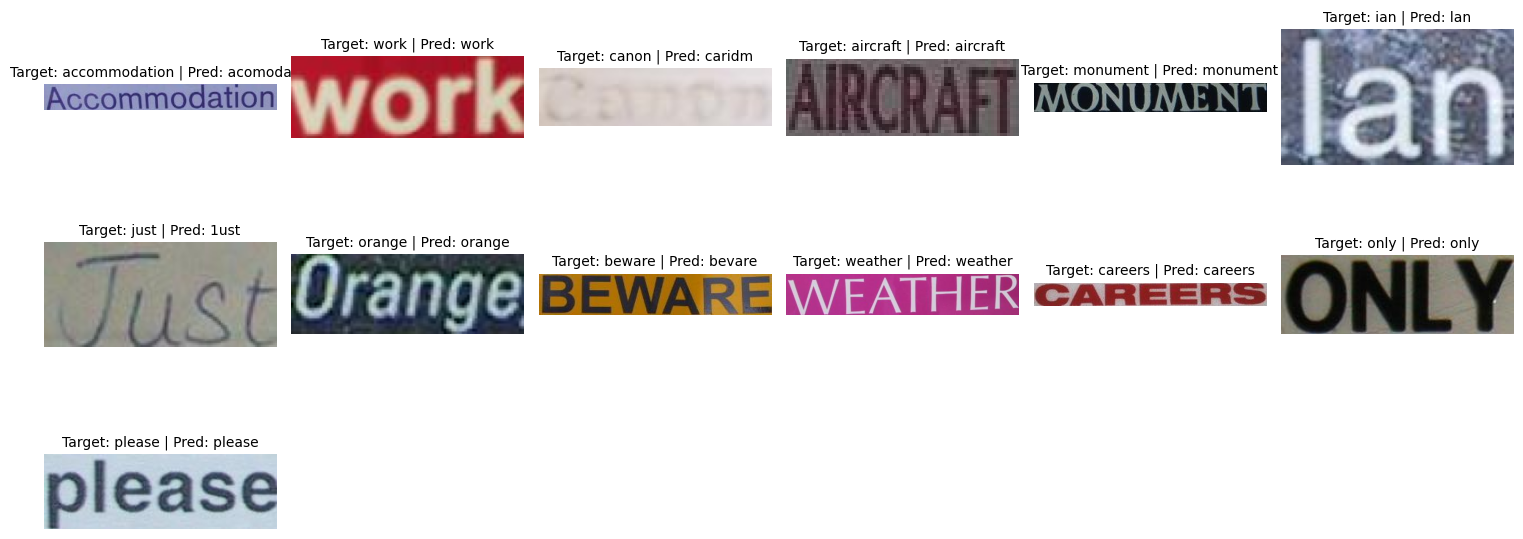

None


In [28]:

print(predict(model,val_loader,device,chars_2_idx,decode,idx_2_chars))